# Lesson 1

In [2]:
%matplotlib inline

In [3]:
from __future__ import division,print_function

import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt

In [36]:
# DATA_PATH = '/home/ubuntu/data/dogscats/sample/'
DATA_PATH = '/home/ubuntu/data/dogscats/'


BATCH_SIZE = 64

In [18]:
import utils; reload(utils)
from vgg16 import Vgg16

In [19]:
from utils import plots

## Create a VGG model

In [20]:
vgg = Vgg16()

In [22]:
batches = vgg.get_batches(DATA_PATH+'train', batch_size=8)
# val_batches = vgg.get_batches(DATA_PATH+'valid', batch_size=BATCH_SIZE)

Found 160 images belonging to 2 classes.


In [25]:
imgs, labels = next(batches)

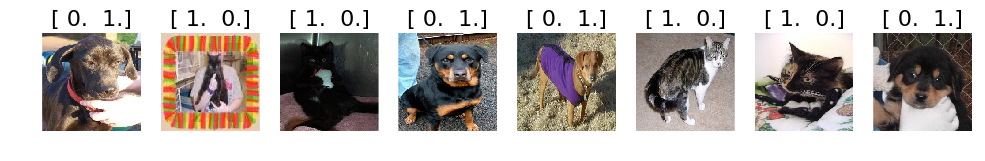

In [26]:
plots(imgs, titles=labels)

In [27]:
vgg.predict(imgs)

(array([ 0.3226,  0.3497,  0.3757,  0.9887,  0.581 ,  0.6981,  0.3282,  0.1262], dtype=float32),
 array([209, 584, 223, 234, 211, 281, 281, 234]),
 [u'Chesapeake_Bay_retriever',
  u'hair_slide',
  u'schipperke',
  u'Rottweiler',
  u'vizsla',
  u'tabby',
  u'tabby',
  u'Rottweiler'])

## Finetune it

In [37]:
batches = vgg.get_batches(path=DATA_PATH+'train', batch_size=64)

Found 23000 images belonging to 2 classes.


In [38]:
vgg.finetune(batches=batches)

In [33]:
vgg.model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_2 (Lambda)                (None, 3, 224, 224)   0           lambda_input_2[0][0]             
____________________________________________________________________________________________________
zeropadding2d_14 (ZeroPadding2D) (None, 3, 226, 226)   0           lambda_2[0][0]                   
____________________________________________________________________________________________________
convolution2d_14 (Convolution2D) (None, 64, 224, 224)  0           zeropadding2d_14[0][0]           
____________________________________________________________________________________________________
zeropadding2d_15 (ZeroPadding2D) (None, 64, 226, 226)  0           convolution2d_14[0][0]           
___________________________________________________________________________________________

In [41]:
vgg.fit(batches, val_batches, nb_epoch=1)

Epoch 1/1
  256/23000 [..............................] - ETA: 666s - loss: 0.0807 - acc: 0.9805

KeyboardInterrupt: 

# Building VGG-16 from scratch

In [42]:
from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image

## Exploring structure

Get the VGG weights and class_index

In [44]:
FILES_URL = 'http://www.platform.ai/models/'
CLASS_FILE='imagenet_class_index.json'

In [45]:
# get_file returns path to the downloaded file
file_path = get_file(CLASS_FILE, FILES_URL+CLASS_FILE, cache_subdir='models')

We need to load this into a dict.

In [46]:
with open(file_path) as f:
    class_dict = json.load(f)

In [47]:
class_dict

{u'344': [u'n02398521', u'hippopotamus'],
 u'0': [u'n01440764', u'tench'],
 u'346': [u'n02408429', u'water_buffalo'],
 u'347': [u'n02410509', u'bison'],
 u'340': [u'n02391049', u'zebra'],
 u'341': [u'n02395406', u'hog'],
 u'342': [u'n02396427', u'wild_boar'],
 u'343': [u'n02397096', u'warthog'],
 u'810': [u'n04264628', u'space_bar'],
 u'811': [u'n04265275', u'space_heater'],
 u'812': [u'n04266014', u'space_shuttle'],
 u'813': [u'n04270147', u'spatula'],
 u'348': [u'n02412080', u'ram'],
 u'349': [u'n02415577', u'bighorn'],
 u'816': [u'n04277352', u'spindle'],
 u'817': [u'n04285008', u'sports_car'],
 u'595': [u'n03496892', u'harvester'],
 u'719': [u'n03935335', u'piggy_bank'],
 u'718': [u'n03933933', u'pier'],
 u'717': [u'n03930630', u'pickup'],
 u'716': [u'n03930313', u'picket_fence'],
 u'715': [u'n03929855', u'pickelhaube'],
 u'714': [u'n03929660', u'pick'],
 u'713': [u'n03924679', u'photocopier'],
 u'712': [u'n03920288', u'Petri_dish'],
 u'711': [u'n03916031', u'perfume'],
 u'710': [u

In [49]:
class_dict['0'][1]

u'tench'

In [51]:
classes = [class_dict[str(i)][1] for i in range(len(class_dict))]

In [52]:
classes[:4]

[u'tench', u'goldfish', u'great_white_shark', u'tiger_shark']

## Create the model

?? Can we do this with just the Conv2D layer?

In [53]:
?Convolution2D

In [82]:
def ConvBlock(model, nb_layers, nb_filters):
    for i in range(nb_layers):
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(nb_filter=nb_filters, nb_row=3, nb_col=3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

In [89]:
def FCBlock(model):
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

### Preprocessing

In [90]:
VGG_MEAN = np.array([123.68, 116.779, 103.939]).reshape((3,1,1))

In [91]:
VGG_MEAN

array([[[ 123.68 ]],

       [[ 116.779]],

       [[ 103.939]]])

In [92]:
def preprocess(x):
    x = x - VGG_MEAN
    return x[:, ::-1]

In [93]:
def VGG_16():
    model = Sequential()
    model.add(Lambda(preprocess, input_shape=(3,224,224)))
    
    ConvBlock(model, 2, 64)
    ConvBlock(model, 2, 128)
    ConvBlock(model, 3, 256)
    ConvBlock(model, 3, 512)
    ConvBlock(model, 3, 512)
    
    model.add(Flatten())
    
    FCBlock(model)
    FCBlock(model)

    model.add(Dense(1000, activation='softmax'))
    return model

In [94]:
model = VGG_16()

### Load the weights

In [97]:
FILE_PATH = get_file('vgg16.h5', FILES_URL+'vgg16.h5', cache_subdir='models')

In [98]:
model.load_weights(FILE_PATH)

## Time to predict

In [110]:
def get_batches(dirname, gen=image.ImageDataGenerator(), 
                shuffle=True, batch_size=BATCH_SIZE, class_mode='categorical'):
    return gen.flow_from_directory(DATA_PATH+dirname, target_size=(224,224), 
                                   shuffle=True, batch_size=batch_size, class_mode='categorical')

In [111]:
batches = get_batches('train', batch_size=8)
val_batches = get_batches('valid')

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [112]:
imgs, labels = next(batches)

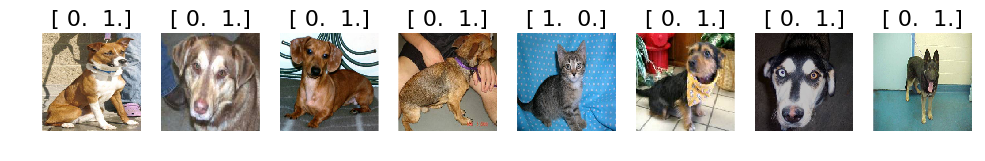

In [113]:
plots(imgs, titles=labels)

In [120]:
def pred_batch(imgs):
    preds = model.predict(imgs)
    idxs = np.argmax(preds, axis=1)
    
    for i in range(len(idxs)):
        print("{} -> {}".format(preds[i, idxs[i]], classes[idxs[i]]))

In [121]:
pred_batch(imgs)

0.887484669685 -> basenji
0.340481638908 -> Chesapeake_Bay_retriever
0.512831926346 -> redbone
0.693037331104 -> Border_terrier
0.551011383533 -> Egyptian_cat
0.653626322746 -> Australian_terrier
0.523167431355 -> Siberian_husky
0.932864010334 -> malinois
